In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [4]:
data = pd.read_csv('../data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [7]:
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [8]:
def weighted_random_recommendation(items_weights, n):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
        n - количество элементов в списке рекомендаций
    """
    items = np.array(items_weights['item_id'])
    it_weights = np.array(items_weights['weight'])
    recs = random.choices(items, weights = it_weights, k = n)

    
    return recs

In [9]:
%%time

items_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights['weight'] = items_weights['sales_value']/items_weights['sales_value'].sum()
items_weights.drop(['sales_value'], axis = 1, inplace = True)
items_weights.head(3)

CPU times: user 114 ms, sys: 19.4 ms, total: 134 ms
Wall time: 147 ms


,item_id,weight
0,25671,2.969296e-06
1,26081,1.403822e-07
2,26093,2.254623e-07


In [10]:
%time
result['weight_rand_rec'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(2)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs


,user_id,actual,weight_rand_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1038886, 6533889, 1002172, 1037063, 850645]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[6602654, 1065593, 1075007, 1126899, 1130776]"


In [11]:
weighted_random_recommendation(items_weights, n=7)

[968072, 961023, 863332, 853172, 15716744, 15830896, 1004906]

Пробовала вычислять веса по разному и по разным столбцам
Например, есть вычислять так #items_weights['weight'] = np.log(items_weights['sales_value']) 
то, у весов получается слишком большой разброс и в выборку попадает практически одно значение
Можно попробовать убирать из списка товаров те, которые уже попали в выборку

Поэтому остановилась на варианте рассчета весов как долю от общих продаж

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [12]:
result = pd.read_csv('../predictions/predictions_basic.csv')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[1011736, 1016274, 51226, 9219941, 932166]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1622526, 1846997, 928009, 970747, 15717358]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [13]:
result['weight_rand_rec'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

In [14]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weight_rand_rec
0,1,[ 821867 834484 856942 865456 889248 ...,"[1011736, 1016274, 51226, 9219941, 932166]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]","[6534178, 944836, 14077330, 1075368, 8090521]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1622526, 1846997, 928009, 970747, 15717358]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]","[1136719, 880310, 5570513, 882305, 862349]"


В связи с тем, что после сохранения и открытия файла csv изменились типы данных, выполним дополнительные преобразования

In [15]:
result['random_recommendation'] = result['random_recommendation'].map(lambda x: x[1:-1].split(', '))
result['popular_recommendation'] = result['popular_recommendation'].map(lambda x: x[1:-1].split(', '))
result['itemitem'] = result['itemitem'].map(lambda x: x[1:-1].split(', '))
result['cosine'] = result['cosine'].map(lambda x: x[1:-1].split(', '))
result['tfidf'] = result['tfidf'].map(lambda x: x[1:-1].split(', '))
result['own_purchases'] = result['own_purchases'].map(lambda x: x[1:-1].split(', '))

In [16]:
data_test = data_test.astype({'item_id': str})

In [17]:
result2 = data_test.groupby('user_id')['item_id'].unique().reset_index()
result2.columns=['user_id', 'actual']
result['actual'] = result2['actual']

In [18]:
type(result['actual'].iloc[0][0])

str

In [19]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [20]:
def precision_at_k_column(recommended_list, bought_list, k=5):
    a = []
    for i in range(recommended_list.shape[0]):
        a.append(precision_at_k(recommended_list.iloc[i], bought_list[i], k=5))
    return np.mean(a)

In [21]:
a = precision_at_k_column(result['random_recommendation'], result['actual'], k=5)
print('средний precision_at_k для random_recommendation {}'.format(a))
b = precision_at_k_column(result['popular_recommendation'], result['actual'], k=5)
print('средний precision_at_k для popular_recommendation {}'.format(b))
d = precision_at_k_column(result['itemitem'], result['actual'], k=5)
print('средний precision_at_k для itemitem {}'.format(d))
e = precision_at_k_column(result['cosine'], result['actual'], k=5)
print('средний precision_at_k для cosine {}'.format(e))
f = precision_at_k_column(result['tfidf'], result['actual'], k=5)
print('средний precision_at_k для tfidf {}'.format(f))
g = precision_at_k_column(result['own_purchases'], result['actual'], k=5)
print('средний precision_at_k для own_purchases {}'.format(g))
h = precision_at_k_column(result['weight_rand_rec'], result['actual'], k=5)
print('средний precision_at_k для weight_rand_rec {}'.format(g))

средний precision_at_k для random_recommendation 0.000881488736532811
средний precision_at_k для popular_recommendation 0.15523996082272282
средний precision_at_k для itemitem 0.13692458374143
средний precision_at_k для cosine 0.1329089128305583
средний precision_at_k для tfidf 0.13898139079333988
средний precision_at_k для own_purchases 0.17969311132876264
средний precision_at_k для weight_rand_rec 0.17969311132876264


Лучший результат получился для own_purchases и weight_rand_rec

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [22]:
data = pd.read_csv('../data/retail_train.csv')

In [23]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()

In [24]:
np.sort(popularity.sales_value)[::-1]

array([467993.62000001,  42645.75      ,  37981.91      , ...,
            0.        ,      0.        ,      0.        ])

In [25]:
data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [26]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

In [27]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [28]:
popularity = popularity.reset_index().sort_values(by=['sales_value', 'index'], ascending=False).set_index('index')
popularity = popularity[:5000]

In [29]:
popularity.shape

(5000, 2)

In [30]:
%%time

items = popularity.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result.head(2)

CPU times: user 228 ms, sys: 4.95 ms, total: 233 ms
Wall time: 238 ms


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[821316, 1060292, 1007210, 13115548, 6443332]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[974204, 959985, 13190349, 1012922, 8019916]"


In [31]:
%%time
popular_recs = popularity.item_id.unique()[:5]
result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

CPU times: user 2.23 ms, sys: 559 µs, total: 2.79 ms
Wall time: 2.35 ms


,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[821316, 1060292, 1007210, 13115548, 6443332]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[974204, 959985, 13190349, 1012922, 8019916]","[6534178, 6533889, 1029743, 6534166, 1082185]"


In [32]:
items_weights = popularity.groupby('item_id')['sales_value'].sum().reset_index()
items_weights['weight'] = items_weights['sales_value']/items_weights['sales_value'].sum()
items_weights.drop(['sales_value'], axis = 1, inplace = True)

In [33]:
result['weight_rand_rec'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,weight_rand_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[821316, 1060292, 1007210, 13115548, 6443332]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 7410251, 819978, 1105938, 912902]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[974204, 959985, 13190349, 1012922, 8019916]","[6534178, 6533889, 1029743, 6534166, 1082185]","[5569471, 868423, 1082627, 1029743, 961554]"


In [34]:
type(result['random_recommendation'][7][0])

int

In [35]:
a = precision_at_k_column(result['random_recommendation'], result['actual'], k=5)
print('средний precision_at_k для random_recommendation {}'.format(a))
b = precision_at_k_column(result['popular_recommendation'], result['actual'], k=5)
print('средний precision_at_k для popular_recommendation {}'.format(b))
c = precision_at_k_column(result['weight_rand_rec'], result['actual'], k=5)
print('средний precision_at_k для weight_rand_rec {}'.format(c))

средний precision_at_k для random_recommendation 0.004701273261508326
средний precision_at_k для popular_recommendation 0.15523996082272282
средний precision_at_k для weight_rand_rec 0.033692458374143


Результаты на всех товарах средний precision_at_k: random_recommendation 0.00088
                                                   popular_recommendation 0.15523 
                                                   weight_rand_rec 0.179693
Вывод - 
для random_recommendation результат улучшился
для popular_recommendation остался таким же, так как выборка одна и та же
для  weight_rand_rec результат ухудшился, так как в выборку стало попадать меньше товаров и покупают не всегда самые популярные товары

**Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей  𝐾**

In [36]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [37]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [38]:
# Заведем фиктивный item_id (если юзер не покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [40]:
np.sort(data.item_id.unique())

array([   25671,    26081,    26093, ..., 18000012, 18024155, 18024556])

In [41]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [42]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 1.48 s, sys: 42.4 ms, total: 1.53 s
Wall time: 1.55 s


In [43]:
recs

[(2381, 78679.0),
 (3408, 72173.0),
 (2148, 57995.0),
 (3947, 17272.0),
 (3587, 14417.0)]

In [44]:
[id_to_itemid[rec[0]] for rec in recs]

[999999, 1082185, 981760, 1127831, 1098066]

In [45]:
%%time

result['itemitem_k5'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 68.1 ms, sys: 11 ms, total: 79.2 ms
Wall time: 81.2 ms


изменим количество соседей на 10

In [46]:
%%time

model2 = ItemItemRecommender(K=10, num_threads=4) # K - кол-во билжайших соседей
model2.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs2 = model2.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 1.5 s, sys: 26.2 ms, total: 1.52 s
Wall time: 1.53 s


In [47]:
%%time

result['itemitem_k10'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model2.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 74.8 ms, sys: 2.81 ms, total: 77.6 ms
Wall time: 78.4 ms


изменим количество соседей на 15

In [48]:
%%time
model3 = ItemItemRecommender(K=15, num_threads=4) # K - кол-во билжайших соседей
model3.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs3 = model3.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

result['itemitem_k15'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model3.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])




CPU times: user 1.69 s, sys: 30.9 ms, total: 1.73 s
Wall time: 1.78 s


Количество соседей 4

In [49]:
%%time
model4 = ItemItemRecommender(K=4, num_threads=4) # K - кол-во билжайших соседей
model4.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs4 = model4.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

result['itemitem_k4'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model4.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])


CPU times: user 1.55 s, sys: 21.9 ms, total: 1.57 s
Wall time: 1.59 s


Количество соседей 3

In [51]:
model5 = ItemItemRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей
model5.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs5 = model5.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

result['itemitem_k3'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model5.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Количество соседей 2

In [52]:
model6 = ItemItemRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей
model6.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs6 = model6.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

result['itemitem_k2'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model6.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Количество соседей 1

In [53]:
model7 = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей
model7.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs7 = model7.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

result['itemitem_k1'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model7.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

количество соседей 6

In [56]:
model8 = ItemItemRecommender(K=6, num_threads=4) # K - кол-во билжайших соседей
model8.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs8 = model8.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

result['itemitem_k6'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model8.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [54]:
result.head(10)

,user_id,actual,random_recommendation,popular_recommendation,weight_rand_rec,itemitem_k5,itemitem_k10,itemitem_k15,itemitem_k4,itemitem_k3,itemitem_k2,itemitem_k1
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[821316, 1060292, 1007210, 13115548, 6443332]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 7410251, 819978, 1105938, 912902]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 1127831]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 995242, 1029743, 840361]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[974204, 959985, 13190349, 1012922, 8019916]","[6534178, 6533889, 1029743, 6534166, 1082185]","[5569471, 868423, 1082627, 1029743, 961554]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 6534178]","[999999, 1082185, 1098066, 6534178, 826249]","[999999, 1082185, 1098066, 6534178, 1127831]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[420647, 908064, 980727, 862860, 952981]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 847789, 1127831, 1130882, 9926758]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 1029743, 6534178, 1127831]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[959409, 895070, 876695, 5574409, 1074516]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 845319, 6534178, 1046957, 13416117]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 1098066]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 995242, 1029743, 826249]","[999999, 1082185, 1029743, 1127831, 995785]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[969977, 1031083, 9220882, 6442520, 1080414]","[6534178, 6533889, 1029743, 6534166, 1082185]","[904129, 1052294, 1007604, 1006184, 6534178]","[999999, 1082185, 981760, 1127831, 1098066]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 6534178, 995242]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 1029743, 1098066, 6534178]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[831557, 895667, 999965, 5995281, 947412]","[6534178, 6533889, 1029743, 6534166, 1082185]","[994825, 845193, 1002418, 1094955, 6534178]","[999999, 1082185, 981760, 995242, 1098066]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 981760, 995242, 1098066]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 995242, 1029743, 1098066]","[999999, 1082185, 1029743, 1098066, 1127831]"
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1129671, 842264, 1135834, 7166672, 1074524]","[6534178, 6533889, 1029743, 6534166, 1082185]","[879504, 889105, 1036501, 6533765, 5567950]","[999999, 1082185, 981760, 1098066, 1127831]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 995242, 1029743, 840361]","[999999, 1082185, 1029743, 6534178, 1127831]"
7,14,"[840601, 867293, 933067, 951590, 952408, 96569...","[6979803, 1004001, 827570, 1137387, 1130951]","[6534178, 6533889, 1029743, 6534166, 1082185]","[962229, 6553438, 1049788, 851676, 6534178]","[999999, 1082185, 981760, 1098066, 995242]","[9

In [57]:
n = precision_at_k_column(result['itemitem_k1'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k1 {}'.format(n))
m = precision_at_k_column(result['itemitem_k2'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k2 {}'.format(m))
l = precision_at_k_column(result['itemitem_k3'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k3 {}'.format(l))
h = precision_at_k_column(result['itemitem_k4'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k4 {}'.format(h))
e = precision_at_k_column(result['itemitem_k5'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k5 {}'.format(e))
k = precision_at_k_column(result['itemitem_k6'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k6 {}'.format(k))
f = precision_at_k_column(result['itemitem_k10'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k10 {}'.format(f))
g = precision_at_k_column(result['itemitem_k15'], result['actual'], k=5)
print('средний precision_at_k для itemitem_k15 {}'.format(g))





средний precision_at_k для itemitem_k1 0.17998694090760692
средний precision_at_k для itemitem_k2 0.192009467841985
средний precision_at_k для itemitem_k3 0.1860920666013712
средний precision_at_k для itemitem_k4 0.14495592556317335
средний precision_at_k для itemitem_k5 0.13692458374143
средний precision_at_k для itemitem_k6 0.14201762977473065
средний precision_at_k для itemitem_k10 0.1509304603330069
средний precision_at_k для itemitem_k15 0.15318315377081293


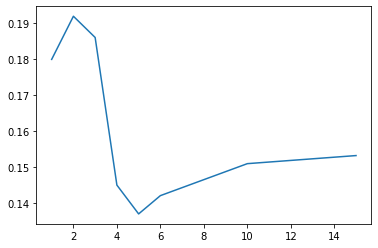

In [58]:
plt.plot([1, 2, 3, 4, 5, 6, 10, 15], [n, m, l, h, e, k, f, g ])

Вывод - качество не линейная функция
лучшее качество достигается при k = 2 ( k = 3 тоже близкое значение)
минимум при k = 5 и ближе к k = 15 выходит на плато